###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2020 David Burris and Adam Wickenheiser

# Basics of Uncertainty Analysis

In this notebook, we'll look at how to calculate the familiar central tendencies, like mean, median, and mode, of a set of data.

## Learning objectives:

1. To be able to propagate uncertainty in measurements through functions of those measurements

## Contents:

1. [Uncertainty propagation](#uncertprop)
1. [Monte Carlo simulation of uncertainty](#montecarlo)
1. [Central Limit Theorem](#central)
1. [Population vs. Sample Mean](#popmean)

<a id='uncertprop'></a>

### Uncertainty propagation

Let's say we want to experimentally determine the strength of a wire under tension.  Strength is a measure of stress in the wire at the point of failure, which is force/area.  In the lab we can measure force and the diameter of the wire; however, each of these measurements has some uncertainty to them.  We can't just assume that our measurements are perfect with infinite accuracy.  So our measurement of force will have some uncertainty (error) and our measurement of diameter will as well.  The question is, how does the uncertainty in each of these measurements combine to create uncertainty in the strength calculation?

Uncertainty based on a combination of factors obeys the following formula:

$U_c^2 f(x_1, x_2, \dotsc, x_n) \approx \sum\limits_{i=1}^n S_{x_i} = \sum\limits_{i=1}^n \left( \dfrac{\partial f}{\partial x_i} \right)^2 u^2(x_i)$

which is called the **Law of Propagation of Uncertainty (LPU)**.  $U_c$ is the uncertainty in the thing we want to calculate (strength in this case), and $u(x_i)$ are the uncertainties in the variables that are measured (force and diameter).  This "law" assumes that the uncertainty between variables is uncorrelated.  So in our case the measurement of force is unrelated to the measurement of diameter (see discussion [here](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Simplification)).

This equation looks really complicated, but in most cases it simplifies substantially.  Let's look at how our example will use this formula.

The strength of the wire is the force/area, which simplifies to

$S = \dfrac{4F}{\pi d^2}$

where $S$ is the strength, $F$ is the force, and $d$ is the diameter of the wire.  Force and diameter are what's being measured, and strength is what's being calculated from those measurements.  So in the LPU, this means $f = S$, $x_1 = F$, and $x_2 = d$.

To use the LPU, we have to take partial derivatives of the formula we want to use with respect to each measured variable.  So we get the following:

$\dfrac{\partial S}{\partial F} = \dfrac{4}{\pi d^2}$

$\dfrac{\partial S}{\partial d} = \dfrac{-8F}{\pi d^3}$

So we finally get

$U_c^2 S(F, d) \approx \left( \dfrac{4}{\pi d^2} \right)^2 u^2(F) + \left( \dfrac{-8F}{\pi d^3} \right)^2 u^2(d)$

Let's plug in some numbers now.  Suppose we measure the force when the wire breaks to be $25.1 \pm 0.6 lb$ and its diameter to be $0.010 \pm 0.001"$.  The first number in each measurement is the "best guess" or most "likely" value of the measurement, usually limited by the precision of the measurement device, and the second number after the $\pm$ is the one standard deviation range in which the "true" value lies in.  This is the **uncertainty** in the measurement.  It turns out that $\pm 1 \sigma$ corresponds to 68% confidence and $\pm 2 \sigma$ corresponds to 95% confidence, as shown in the following figure.

<img src="https://github.com/AdaWick/CDS/blob/master/Data%20Analysis/images/normal%20distribution.png?raw=true" width="700" />

(We'll review how to calculate these percentages in Python in a little while.)

Plugging these numbers into the LPU gives

$U_c^2 S(F, d) \approx \left( \dfrac{4}{\pi (0.010")^2} \right)^2 (0.6 lb)^2 + \left( \dfrac{-8(25.1 lb)}{\pi (0.010")^3} \right)^2 (0.001")^2 = 4.14 \times 10^9 psi^2$

$U_c S(F, d) \approx 64.4 kpsi$

which is the uncertainty in the strength calculation.

The mean or most likely value of strength uses the mean value of the force and diameter:

$S = \dfrac{4F}{\pi d^2} = \dfrac{4(25.1 lb)}{\pi (0.010")^2} = 320 kpsi$

If we want 95% confidence, we must add and subtract $2\times$ the uncertainty in the strength calculation:

$S = 320 \pm 2(64.4) kpsi = 320 \pm 129 kpsi$

So, with the uncertainty in these measurements we can only say that the strength lies in the range $191 kpsi$ to $449 kpsi$ with 95% confidence.  If we want to tighten this range, we'll need to take more data (which reduces uncertainty), use more precise instruments (which also reduces uncertainty), or reduce our confidence requirement (which is usually a bad idea!).

Now, we'll take a look at solving this problem in Python.

First let's import the libraries we will need for this lesson.  We'll use:
* [numpy](https://numpy.org/doc/stable/index.html) for math functions
* [matplotlib.pyplot](https://matplotlib.org/2.0.2/index.html) for plotting
* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html) for statistical functions
* [sympy](https://docs.sympy.org/latest/index.html) for sybolic math
* [random](https://docs.python.org/3/library/random.html) for generating random numbers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sympy as sym
import random

Let's next compute the confidence of data falling within $\pm 2 \sigma$, which we stated earlier was 95%.  Remember that **z-score** is another term for number of standard deviations above or below the mean.

In [2]:
min_range = -2.0      # minimum z-score
max_range = 2.0       # maximum z_score

perc = 100*(stats.norm.cdf(max_range) - stats.norm.cdf(min_range))   # confidence between min_range and max_range

print('The confidence of data between',min_range,'and',max_range,'standard deviations of the mean is',perc,'%')

The confidence of data between -2.0 and 2.0 standard deviations of the mean is 95.44997361036415 %


Now, let's use Python to compute those pesky partial derivatives:

In [3]:
F,d = sym.symbols('F,d')   # create symbolic variables F and d
S = 4*F/(sym.pi*d**2)
print(S)

# compute partial derivatives symbolically
dSdF = sym.diff(S,F)
print('dS/dF =',dSdF)
dSdd = sym.diff(S,d)
print('dS/dd =',dSdd)

4*F/(pi*d**2)
dS/dF = 4/(pi*d**2)
dS/dd = -8*F/(pi*d**3)


See how these partial derivatives match the ones we got by hand!

Now, we can plug in the numerical values into these symbolic formulas and compare them to our previous hand calculations.

In [4]:
F_mean = 25.1      # mean force measured [lb]
F_std = 0.6        # standard deviation of force measured [lb]
d_mean = 0.01      # mean of diameter measured [in]
d_std = 0.001      # standard deviation of diameter measured [in]

# evaluate partial derivatives
dSdF_eval = float(dSdF.evalf(subs={d: d_mean}))              # this syntax means substitute d_mean for d
dSdd_eval = float(dSdd.evalf(subs={F: F_mean, d: d_mean}))
Uc = np.sqrt(dSdF_eval**2*F_std**2 + dSdd_eval**2*d_std**2)
print('Uncertaintly in strength calculation =',Uc/1000,'kpsi')

Uncertaintly in strength calculation = 64.37154629022497 kpsi


Note that this matches our previous hand calculation of $U_c S(F, d) \approx 64.4 kpsi$.

<a id='montecarlo'></a>

### Monte Carlo simulation of uncertainty

Let's demonstrate the uncertainty in averaging a set of 5 coin tosses.  If we assign 1 to heads and 0 to tails, the average of 5 tosses should be 0.5.  Of course, a single experiment of 5 coin tosses cannot yield exactly 0.5 because we are using an odd number of coin tosses, so it's impossible to get the same number of heads and tails.  But if we aggregate a large number of these experiments, their average should be 0.5.  However, there will still be quite a bit of variation from one experiment to the next since we're only looking at 5 tosses at a time.

The question we will look at is how much uncertainty is there in the average of 5 coin tosses.  Another way to put it is: how certain can you be that a coin is fair if you only toss it 5 times?

First, let's simulate a single experiment consisting of 5 coin tosses.

In [5]:
n = 5                           # number of coin tosses per experiment
results_array = np.zeros(n)     # create an array of zeros to store the results
for i in range(n):
    results_array[i] = random.randint(0,1)     # compute a random integer between 0 and 1

print(results_array)
print('Average of this experiment =',np.mean(results_array))

[1. 0. 0. 1. 1.]
Average of this experiment = 0.6


If you keep re-running the previous cell, you'll see a different array of 0s and 1s, showing that the experiment is random (well technically [pseudorandom](https://en.wikipedia.org/wiki/Pseudorandom_number_generator)).

Let's repeat this experiment 10 times and calculate the mean and standard deviation of the averages for 10 experiments.

In [6]:
m = 10                          # number of experiments to run
results_array = np.zeros((m,n)) # create an array of zeros to store the results of m experiments
averages_array = np.zeros(m)    # create an array of zeros to store the averages of m experiments

for k in range(m):
    for i in range(n):
        results_array[k,i] = random.randint(0,1)     # compute a random integer between 0 and 1

    averages_array[k] = np.mean(results_array[k,:])
    print(results_array[k,:])
    print('Average of experiment',k,'=',averages_array[k])
    
print('Mean of',m,'averages =',np.mean(averages_array))
print('Standard deviation of',m,'averages =',np.std(averages_array,ddof=1))

[1. 0. 1. 0. 1.]
Average of experiment 0 = 0.6
[0. 1. 1. 0. 0.]
Average of experiment 1 = 0.4
[0. 0. 1. 1. 0.]
Average of experiment 2 = 0.4
[0. 1. 0. 0. 0.]
Average of experiment 3 = 0.2
[0. 1. 1. 0. 1.]
Average of experiment 4 = 0.6
[1. 1. 0. 1. 0.]
Average of experiment 5 = 0.6
[0. 0. 0. 1. 1.]
Average of experiment 6 = 0.4
[0. 1. 1. 0. 0.]
Average of experiment 7 = 0.4
[1. 0. 1. 1. 1.]
Average of experiment 8 = 0.8
[0. 1. 1. 0. 0.]
Average of experiment 9 = 0.4
Mean of 10 averages = 0.4800000000000001
Standard deviation of 10 averages = 0.16865480854231354


We can see that the average generally isn't that close to 0.5.  Let's increase the number of experiments to 500 (this time we won't print out each experiment):

In [7]:
m = 500                          # number of experiments to run
results_array = np.zeros((m,n)) # create an array of zeros to store the results of m experiments
averages_array = np.zeros(m)    # create an array of zeros to store the averages of m experiments

for k in range(m):
    for i in range(n):
        results_array[k,i] = random.randint(0,1)     # compute a random integer between 0 and 1

    averages_array[k] = np.mean(results_array[k,:])
    
print('Mean of',m,'averages =',np.mean(averages_array))
print('Standard deviation of',m,'averages =',np.std(averages_array,ddof=1))

Mean of 500 averages = 0.49360000000000004
Standard deviation of 500 averages = 0.2204909806434045


Let's use the LPU to compute the uncertainty in the computed averages of 5 coin tosses.

The function we are using is the average of 5 tosses, which represent the measured variables $X_1, \dotsc, X_5$.  So,

$F = \dfrac{X_1 + \dotsb X_5}{5}$

All of the partial derivatives are the same:

$\dfrac{\partial F}{\partial X_i} = \dfrac{1}{5}$

and the uncertainty in a single coin toss is $ u(X_i) = 0.5$.

Therefore,

$\begin{align*}U_c^2 F(X_1, \dotsc, X_5) &\approx \left( \dfrac{1}{5} \right)^2 u^2(X_1) + \dotsb + \left( \dfrac{1}{5} \right)^2 u^2(X_5) \\
&= 5 \left( \dfrac{1}{5} \right)^2 \left( \dfrac{1}{2} \right)^2 \\
&= \dfrac{1}{20} \end{align*}$

so

$U_c F(X_1, \dotsc, X_5) \approx \dfrac{1}{\sqrt{20}} = 0.224$

which is close to the calculated value we get from 100 experiments.

We can also verify that the uncertainty of a coin toss is 0.5 by taking the standard deviation of all of the 2500 coin tosses together:

In [8]:
print('Uncertainty of a single coin toss =',np.std(results_array,ddof=1))

Uncertainty of a single coin toss = 0.5000590601373504


<a id='central'></a>

### Central Limit Theorem

Two of the tenets of the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) have been demonstrated by the preceeding simulations of coin tosses, namely:

1. The sample mean approaches the population mean as the number of samples increases (We saw that in the case $m = 500$ the mean of the experiments was very close to 0.5, the average number of heads in an arbitrarily large "population" of coins.)

2. The standard deviation (uncertainty) of the samples approaches the standard deviation (uncertainty) of the population divided by $\sqrt{n}$ (We saw the uncertainty in the population was $0.5$ and the uncertainty in the sample in the case $m = 500$ was approximately $\dfrac{0.5}{\sqrt{5}} = 0.224$

Now we will show the third tenet:

3. The distribution of the sample mean approaches the [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution) (the famous "bell curve") regardless of the probability distribution of the population.

First, let's look at the distribution of the population by simulating 10,000 coin flips.

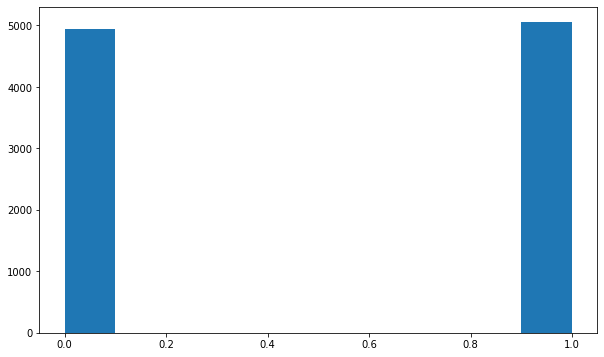

In [9]:
n = 10000                       # number of coin flips
results_array = np.zeros(n)     # create an array of zeros to store the results
for i in range(n):
    results_array[i] = random.randint(0,1)     # compute a random integer between 0 and 1

plt.figure(figsize=(10,6))
plt.hist(results_array);

You can see here that roughly 5000 are in the 0-0.1 bin and 5000 are in the 0.9-1.0 bin of the histogram (so basically half are heads and half are tails).

Now let's do an increasing number of experiments, where each experiment is to average 10 coin tosses.  So the result of each experiment will be a number like 0.0, 0.1, 0.2, ... 0.9, or 1.0.  Let's see what happens as we do more and more experiments.

5 averages: mean = 0.62 , standard deviation = 0.10954451150103324
10 averages: mean = 0.41999999999999993 , standard deviation = 0.19321835661585918
100 averages: mean = 0.506 , standard deviation = 0.15296398202838404
500 averages: mean = 0.5072 , standard deviation = 0.160623035455809
5000 averages: mean = 0.49743999999999994 , standard deviation = 0.15845020572261403


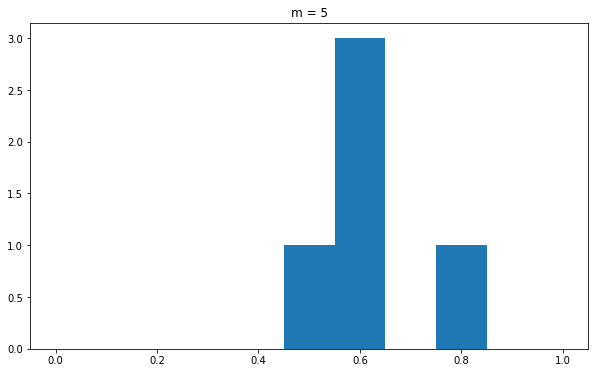

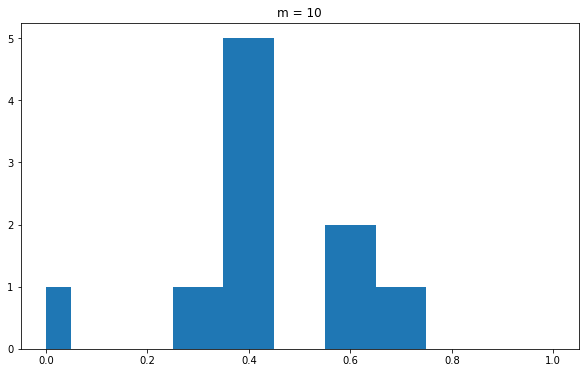

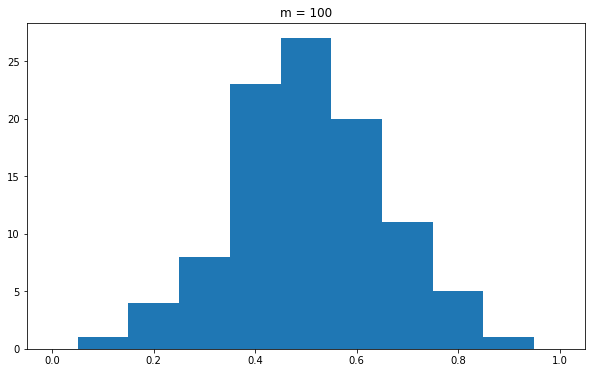

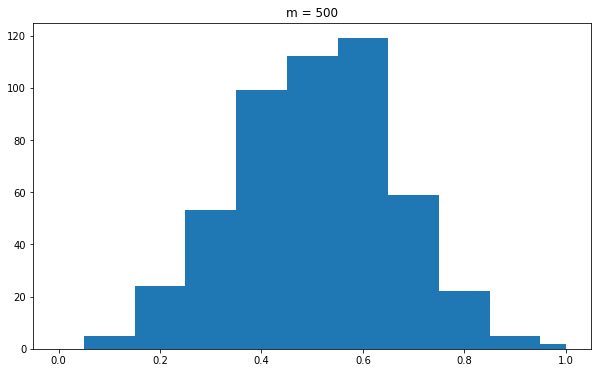

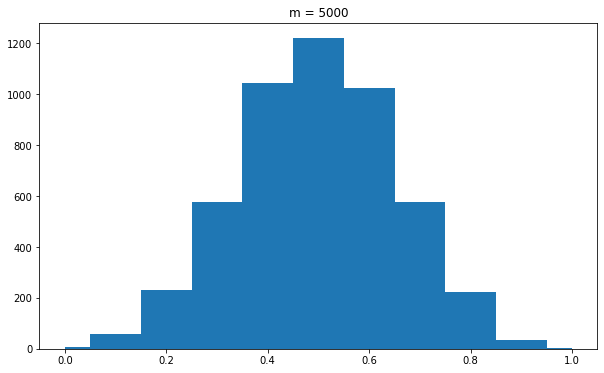

In [10]:
n = 10                                   # number of coin tosses in each experiment
m_array = np.array([5,10,100,500,5000])     # number of experiments to run
for m in m_array:
    results_array = np.zeros((m,n)) # create an array of zeros to store the results of m experiments
    averages_array = np.zeros(m)    # create an array of zeros to store the averages of m experiments

    for k in range(m):
        for i in range(n):
            results_array[k,i] = random.randint(0,1)     # compute a random integer between 0 and 1

        averages_array[k] = np.mean(results_array[k,:])
    
    print(m,'averages: mean =',np.mean(averages_array),', standard deviation =',np.std(averages_array,ddof=1))
    
    plt.figure(figsize=(10,6))
    plt.hist(averages_array,bins=[0, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1])
    plt.title('m = '+str(m))

You can see from these examples that the more experiments we run, the closer the averages of the experiments adhere to a normal distribution.

Also, the standard deviation of the experiments seems to be converging to $\dfrac{0.5}{\sqrt{10}} = 0.158$.

Now, let's look at what happens when we increase the number of coin tosses we average $n$ from 10 to some larger numbers.  We expect that averaging a larger number of coin tosses should lead to more consistent (i.e. less uncertain) results.  The results should be close to 0.5 with a smaller uncertainty as the number $n$ increases.

500 averages of 10 coin tosses: mean = 0.4992 , standard deviation = 0.1569989086415229
500 averages of 50 coin tosses: mean = 0.5062000000000001 , standard deviation = 0.07150794902349734
500 averages of 100 coin tosses: mean = 0.50066 , standard deviation = 0.05248689501481864
500 averages of 500 coin tosses: mean = 0.4991479999999999 , standard deviation = 0.023321790407591608
500 averages of 1000 coin tosses: mean = 0.49933 , standard deviation = 0.016529475100383214


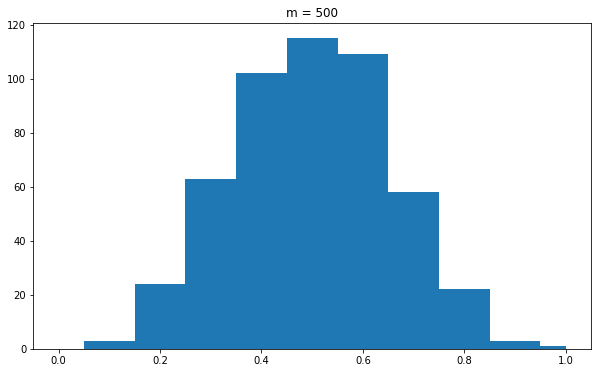

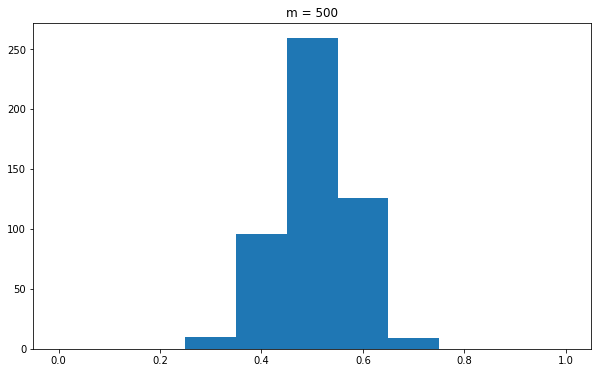

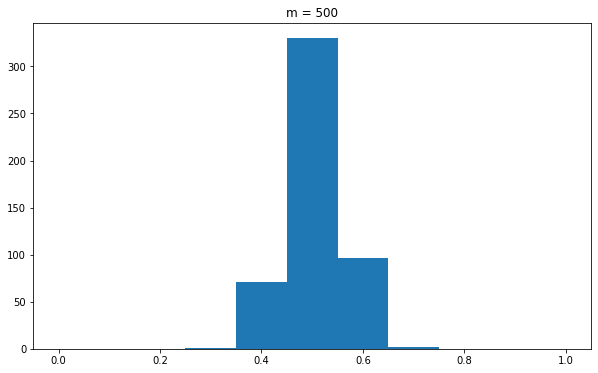

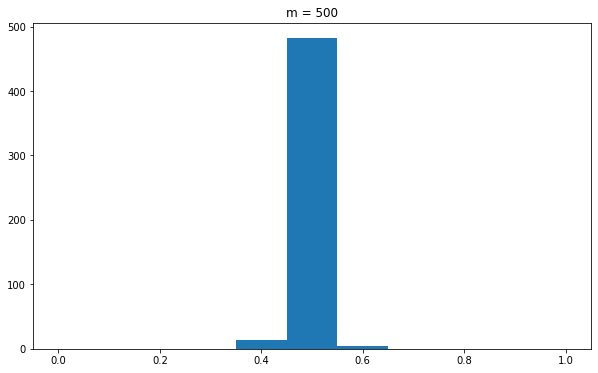

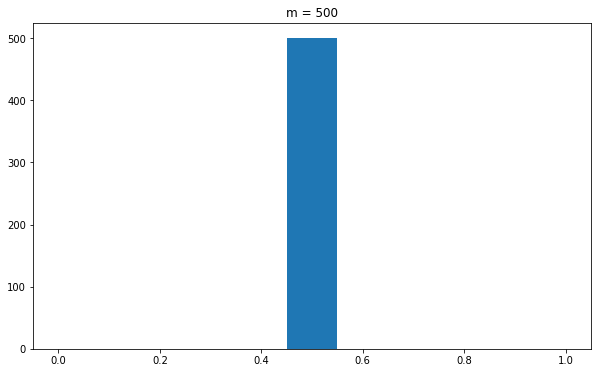

In [11]:
n_array = np.array([10, 50, 100, 500, 1000])     # number of coin tosses in each experiment
m = 500                                          # number of experiments to run
std_array = []                                   # save the standard deviation for each n
for n in n_array:
    results_array = np.zeros((m,n)) # create an array of zeros to store the results of m experiments
    averages_array = np.zeros(m)    # create an array of zeros to store the averages of m experiments

    for k in range(m):
        for i in range(n):
            results_array[k,i] = random.randint(0,1)     # compute a random integer between 0 and 1

        averages_array[k] = np.mean(results_array[k,:])
    
    std_array.append(np.std(averages_array,ddof=1))
    print(m,'averages of',n,'coin tosses: mean =',np.mean(averages_array),', standard deviation =',std_array[-1])
    
    plt.figure(figsize=(10,6))
    plt.hist(averages_array,bins=[0, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1])
    plt.title('m = '+str(m))

Let's plot the standard deviation as a function of $n$.  It should theoretically follow the trend $\sigma_{\bar{X}} = \dfrac{0.5}{\sqrt{n}}$ given by the Central Limit Theorem.

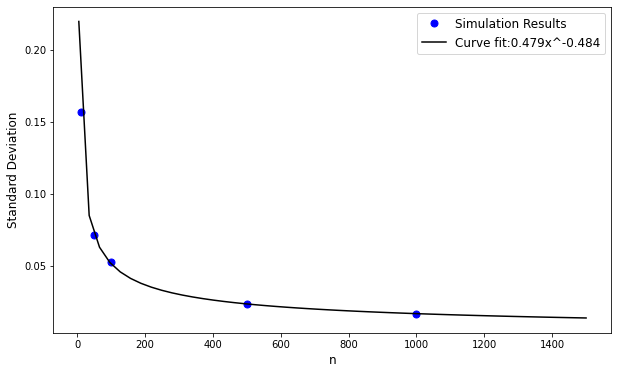

In [12]:
plt.figure(figsize=(10,6))
plt.plot(n_array,std_array,linestyle='None',marker='.',color='b',markersize=14,label='Simulation Results')
plt.ylabel('Standard Deviation',size=12)
plt.xlabel('n',size=12)

from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x**b

popt, pcov = curve_fit(func, n_array, std_array)

n_fit = np.linspace(n_array[0]/2,1.5*n_array[-1])
plt.plot(n_fit,func(n_fit,*popt),'k',label=f'Curve fit:{popt[0]:.3f}x^{popt[1]:.3f}')
plt.legend(fontsize=12);

This plot validates the theory: as we average over larger sets of data (increase $n$), the variability (uncertainty) in that average decreases.  This makes sense: if you want to find the average of a huge population, the more samples of that population you can average over, the more likely your calculation will be consistent with the (unknown) population average.  (I say this is "unknown" because it's usually impossible to sample every single member of a population.)

<a id='popmean'></a>

### Population vs. Sample Mean

Let's say we want to determine the mean of a population but we can only sample a small subset of it.  For example, we'd like to poll 1000 people and try to infer something about the whole country from that data.  If 600 out of 1000 people answered 'Yes' to a survey question, we'd like to say 60% of the entire country feels the same way, plus or minus some error.  The Central Limit Theorem tells us how to compute that error.

For the sake of simulation, let's say the population has a normal distribution with mean $\mu = 1068$ and standard deviation $\sigma = 216$.  Let's generate 100 random numbers from this distribution and compute their mean and standard deviation.  100 data points is a relatively large sample so its statistics should be close to the population's.

In [13]:
pop_mean = 1068      # population mean [in]
pop_std = 216        # population standard deviation [in]
n = 100              # random data to generate

data_array = np.zeros(n)     # create an array of zeros to store the random data
for i in range(n):
    data_array[i] = random.gauss(pop_mean,pop_std)     # generate a random number from a Gaussian (normal) distribution
    
print(n,'samples: Mean =',np.mean(data_array),', Standard deviation =',np.std(data_array))

100 samples: Mean = 1079.9501391061558 , Standard deviation = 218.21984912368634


This is pretty close to the mean and standard deviation of the underlying population.

If you run the previous cell over and over, you'll get a slightly different value for the sample mean, despite the fact that the mean of the population is constant.  But how much will the sample mean vary?  The Central Limit Theorem tells us that the sample mean will have a standard deviation of

$\sigma_{\hat{X}} = \dfrac{\sigma}{\sqrt{n}} = \dfrac{216}{\sqrt{100}} = 21.6

Using a `for` loop, let's repeat the previous experiment 50 times and take the mean and standard deviations of the 50 sample means and see if this theory holds up.

In [14]:
pop_mean = 1068      # population mean [in]
pop_std = 216        # population standard deviation [in]
n = 100              # random data to generate
m = 50               # times to generate and average n data points
data_array = np.zeros((m,n))    # create an array of zeros to store the random data
averages_array = np.zeros(m)    # create an array of zeros to store the averages of m experiments

for k in range(m):
    for i in range(n):
        data_array[k,i] = random.gauss(pop_mean,pop_std) # generate a random number from a Gaussian (normal) distribution

    averages_array[k] = np.mean(data_array[k,:])
    
print('Mean of',m,'averages =',np.mean(averages_array))
print('Standard deviation of',m,'averages =',np.std(averages_array,ddof=1))

Mean of 50 averages = 1069.4318696168489
Standard deviation of 50 averages = 22.257869889514662


This exercise demonstrates the validity of the Central Limit Theorem.  In practice you would not poll 100 people 50 times, but what this simulation shows is that if you polled 100 people, you can report the mean of this sample plus or minus the sample mean standard deviation given by the Central Limit Theorem without having to actually run the poll 50 times.